# DSCI 100 – Project: Planning Stage (Individual)

**Title:** Predicting High-Load Hours on a Minecraft Research Server  
**Name:** Angel (Anjiu Shi)  
**Student Number:** 41909375  
**Section:** DSCI 100  

In this notebook, I explore usage patterns of a Minecraft research server and plan a data science project to predict high-load time windows.


In [1]:
# Load packages
library(readr)
library(dplyr)
library(lubridate)
library(ggplot2)

# Load data (assumes players.csv and sessions.csv are in the same folder)
players  <- read_csv("players.csv")
sessions <- read_csv("sessions.csv")

head(players)
head(sessions)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column type

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


## 1. Data Description

This project uses two files: `players.csv` and `sessions.csv`.  
The **players** data has 196 records with variables like experience level, newsletter subscription, total play hours, gender, and age. Most players are teenagers or young adults (15–25 years old). The dataset is mostly male, and most players describe themselves as *Amateur* or *Regular*. A few are *Veteran* or *Pro*.  

The **sessions** data includes 1,535 rows, each showing one play session. I used the start and end times to compute session duration. Most sessions last under 30 minutes, while a few go on for hours, showing that some players are much more active. From the timestamps, I also created `hour_of_day` and `weekday`, which are useful for studying when the server is busiest. 


In [2]:
# Check structure and summary
glimpse(players)
glimpse(sessions)

# Compute summary stats for players
players_summary <- players |>
  summarise(
    n_players = n(),
    mean_age = mean(Age, na.rm = TRUE),
    mean_played = mean(played_hours, na.rm = TRUE),
    median_played = median(played_hours, na.rm = TRUE)
  )

players_summary


Rows: 196
Columns: 7
$ experience   <chr> "Pro", "Veteran", "Veteran", "Amateur", "Regular", "Amate…
$ subscribe    <lgl> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…
$ hashedEmail  <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ name         <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", "Adrian…
$ gender       <chr> "Male", "Male", "Male", "Female", "Male", "Female", "Fema…
$ Age          <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 47, 22, 23, 17, 25, 22, 17…
Rows: 1,535
Columns: 5
$ hashedEmail         <chr> "bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8a…
$ start_time          <chr> "30/06/2024 18:12", "17/06/2024 23:33", "25/07/202…
$ end_time            <chr> "30/06/2024 18:24", "17/06/2024 23:46", "25/07/202…
$ original_start_time <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…
$ original_end_time   <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+

n_players,mean_age,mean_played,median_played
<int>,<dbl>,<dbl>,<dbl>
196,21.13918,5.845918,0.1


In [3]:
# Convert times and create new variables
sessions_processed <- sessions |>
  mutate(
    start_time = dmy_hm(start_time),
    end_time = dmy_hm(end_time),
    duration_min = as.numeric(difftime(end_time, start_time, units = "mins")),
    hour_of_day = hour(start_time),
    weekday = wday(start_time, label = TRUE)
  )

summary(sessions_processed$duration_min)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   3.00    9.00   30.00   50.86   73.00  259.00       2 

## 2. Research Question

The broad question for this project is:  
**“When are the busiest times on the Minecraft research server?”**  

My specific question is:  
**“Can the day of week and time of day predict whether the server will experience a high number of sessions (top 25% of all hours)?”**  

This question is meaningful because the research team can use it to allocate server resources more efficiently. For example, if certain hours consistently show high load, they can schedule maintenance during quieter periods and ensure the server capacity is sufficient when traffic peaks.


In [4]:
# Aggregate to hourly level
sessions_by_hour <- sessions_processed |>
  mutate(hour_start = floor_date(start_time, "hour")) |>
  count(hour_start, name = "n_sessions") |>
  mutate(
    weekday = wday(hour_start, label = TRUE),
    hour_of_day = hour(hour_start)
  )

# Calculate threshold for "high load" hours
threshold <- quantile(sessions_by_hour$n_sessions, probs = 0.75, na.rm = TRUE)
threshold

sessions_by_hour <- sessions_by_hour |>
  mutate(high_load = n_sessions >= as.numeric(threshold))

table(sessions_by_hour$high_load)


75% 
  2


FALSE  TRUE 
  593   355 

## 3. Exploratory Data Analysis (EDA)

The histogram of total play hours shows that most players spent little time on the server, while a few played much longer. The bar chart of sessions by hour shows activity climbing in the afternoon and peaking around 7–10 p.m., which makes sense since many players log in after school or work.  

The heatmap of weekday × hour shows that weekends are busier than weekdays, especially Saturday evenings. Early morning hours have very few sessions. These trends suggest clear daily and weekly patterns that can help predict high-load hours.

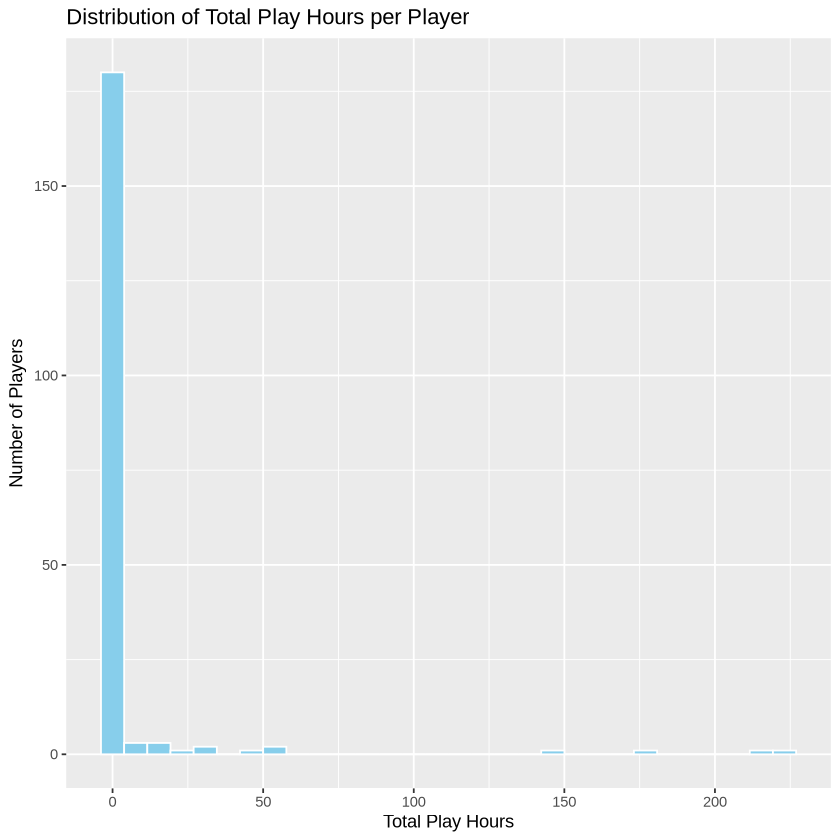

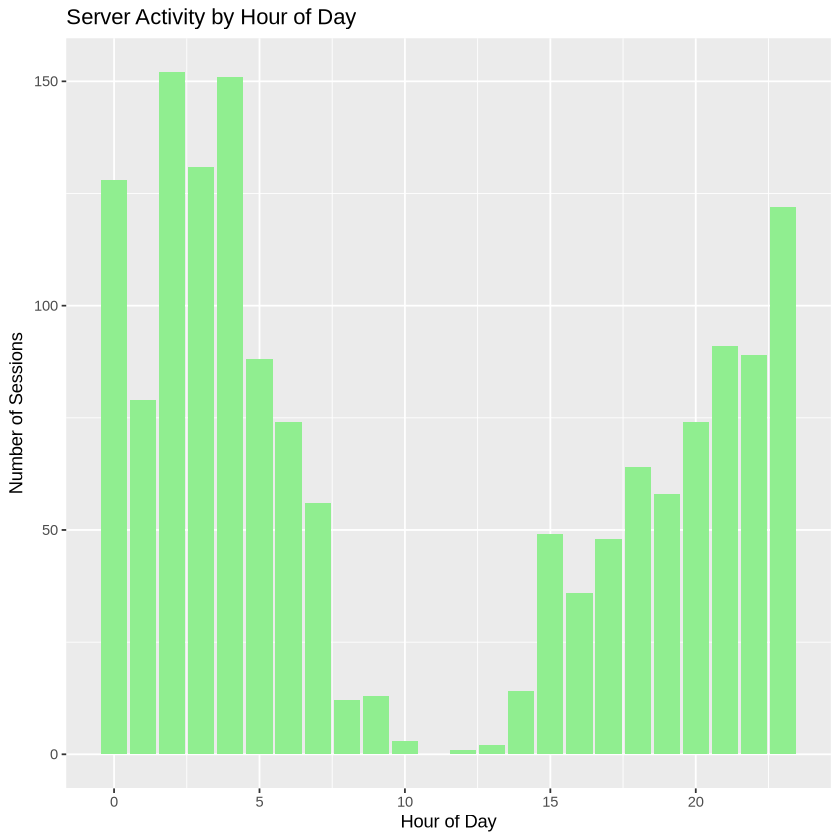

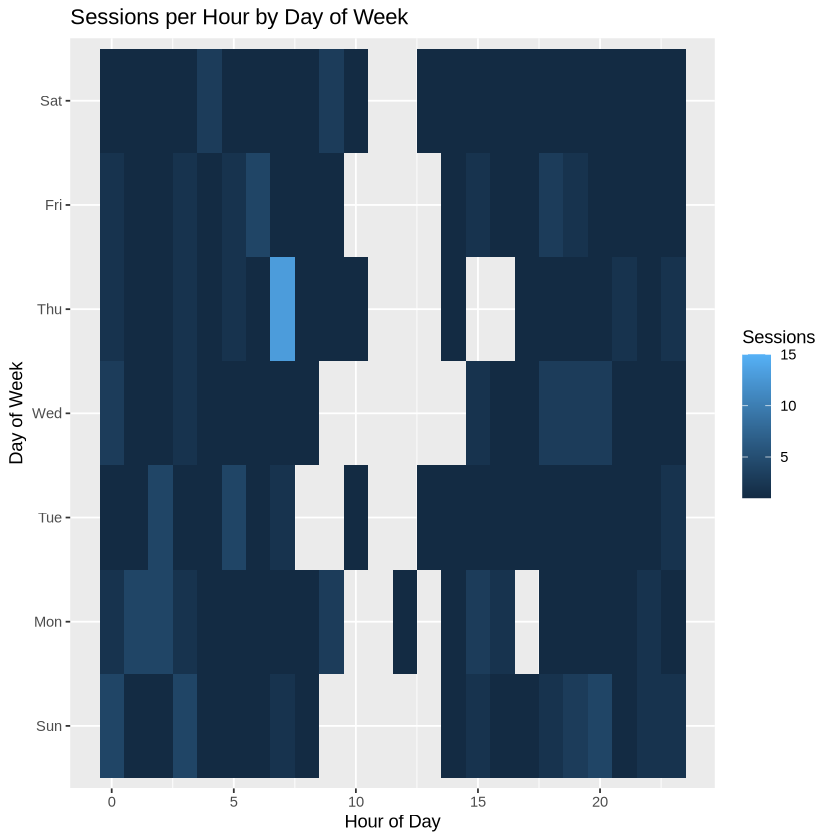

In [5]:
# Histogram of play hours
ggplot(players, aes(x = played_hours)) +
  geom_histogram(bins = 30, fill = "skyblue", color = "white") +
  labs(
    title = "Distribution of Total Play Hours per Player",
    x = "Total Play Hours",
    y = "Number of Players"
  )

# Sessions by hour of day
sessions_processed |>
  count(hour_of_day, name = "n_sessions") |>
  ggplot(aes(x = hour_of_day, y = n_sessions)) +
  geom_col(fill = "lightgreen") +
  labs(
    title = "Server Activity by Hour of Day",
    x = "Hour of Day",
    y = "Number of Sessions"
  )

# Heatmap of weekday × hour
sessions_by_hour |>
  ggplot(aes(x = hour_of_day, y = weekday, fill = n_sessions)) +
  geom_tile() +
  labs(
    title = "Sessions per Hour by Day of Week",
    x = "Hour of Day",
    y = "Day of Week",
    fill = "Sessions"
  )


## 4. Methods and Plan
*(To be added)*

## 5. GitHub Repository
*(To be added)*